In [99]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [100]:
df = pd.read_excel('DS_FF_6.xlsx')
df.tail()

,Excesso_O2,T_out_coal_mill_A,Mill_A_classifier_velocity,Secondary_air_flow_A,Pressao_do_coletor_de_Ar_Secundario,Pressao_do_coletor_de_Ar_Primario,Flow_primary_air_Mill_A,Efficiency
2187,1.46646,78.22266,110.03914,71.97926,16.30931,89.64905,23.81188,0.84529
2188,1.52760,78.22266,109.81761,72.08643,16.22159,89.27490,23.86728,0.84827
2189,1.58930,78.22266,109.55209,71.19142,16.31651,88.74727,23.69873,0.84845
2190,1.55646,78.22266,109.45068,71.10107,16.40381,88.99776,23.70218,0.84905
2191,1.33080,78.22266,109.79638,71.37047,16.32463,88.32266,23.83669,0.84346


In [101]:
df_2=df.drop_duplicates(subset='Mill_A_classifier_velocity', keep='first', inplace=False)
df_2.shape

(2192, 8)

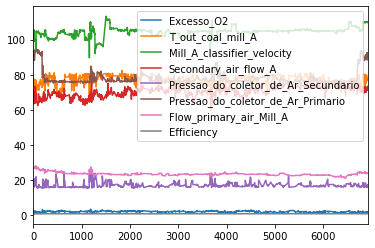

In [30]:
df_2.plot()
plt.legend(loc='best')
plt.show()

In [33]:
import pandas_profiling as pdpf
pdpf.ProfileReport(df)

In [102]:
train_dataset = df_2.sample(frac=0.9,random_state=0)
test_dataset = df_2.drop(train_dataset.index)
print(len(train_dataset), 'train examples')
print(len(test_dataset), 'test examples')

1973 train examples
219 test examples


In [103]:
train_stats = train_dataset.describe()
train_stats.pop("Efficiency")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Excesso_O2,1973.0,2.012473,0.385671,1.00100,1.72097,2.02074,2.32115,3.42856
T_out_coal_mill_A,1973.0,76.520401,2.788129,65.11230,75.00000,76.97754,78.81556,83.18537
Mill_A_classifier_velocity,1973.0,104.607206,2.893888,89.50849,103.73748,104.78271,105.43113,113.26989
Secondary_air_flow_A,1973.0,70.046394,2.691174,59.87823,68.30874,70.19131,72.16137,77.38828
Pressao_do_coletor_de_Ar_Secundario,1973.0,17.091273,1.435106,15.54818,16.13449,16.50617,17.59745,23.77950
Pressao_do_coletor_de_Ar_Primario,1973.0,78.778865,4.995688,75.01723,76.13525,76.50573,78.41612,94.06280
Flow_primary_air_Mill_A,1973.0,23.817061,1.088061,20.90725,23.17951,23.59367,24.01328,28.05685


In [104]:
train_labels = train_dataset.pop('Efficiency')
test_labels = test_dataset.pop('Efficiency')

In [105]:
def norm(x):
      return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [106]:
def build_model():
    model = keras.Sequential([
    layers.Dense(6, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.2),    
    layers.Dense(3, activation=tf.nn.relu),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [107]:
model = build_model()

In [108]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 6)                 48        
_________________________________________________________________
dropout_8 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 4         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [109]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


array([[1.2032497 ],
       [0.2756837 ],
       [0.87261456],
       [0.5469916 ],
       [0.48875386],
       [1.165028  ],
       [0.571052  ],
       [0.06129101],
       [0.42455655],
       [0.18011999]], dtype=float32)

In [110]:
# Display training progress by printing a single dot for each completed epoch

EPOCHS = 100

history = model.fit(
  normed_train_data.to_numpy(), train_labels.to_numpy(),
  epochs=EPOCHS, validation_split = 0.2)
  

Train on 1578 samples, validate on 395 samples
Epoch 1/100
1578/1578 [==============================] - 1s 400us/sample - loss: 0.1781 - mae: 0.5122 - mse: 0.3696 - val_loss: 0.1194 - val_mae: 0.4230 - val_mse: 0.2389
Epoch 2/100
1578/1578 [==============================] - 0s 38us/sample - loss: 0.1116 - mae: 0.3985 - mse: 0.2247 - val_loss: 0.0766 - val_mae: 0.3337 - val_mse: 0.1531
Epoch 3/100
1578/1578 [==============================] - 0s 35us/sample - loss: 0.0757 - mae: 0.3195 - mse: 0.1516 - val_loss: 0.0490 - val_mae: 0.2583 - val_mse: 0.0980
Epoch 4/100
1578/1578 [==============================] - 0s 35us/sample - loss: 0.0494 - mae: 0.2547 - mse: 0.0988 - val_loss: 0.0285 - val_mae: 0.1932 - val_mse: 0.0569
Epoch 5/100
1578/1578 [==============================] - 0s 36us/sample - loss: 0.0386 - mae: 0.2177 - mse: 0.0773 - val_loss: 0.0216 - val_mae: 0.1669 - val_mse: 0.0432
Epoch 6/100
1578/1578 [==============================] - 0s 36us/sample - loss: 0.0293 - mae: 0.1888 -

Epoch 46/100
1578/1578 [==============================] - 0s 36us/sample - loss: 7.4044e-05 - mae: 0.0095 - mse: 1.4809e-04 - val_loss: 8.5119e-05 - val_mae: 0.0105 - val_mse: 1.7024e-04
Epoch 47/100
1578/1578 [==============================] - 0s 35us/sample - loss: 7.5573e-05 - mae: 0.0096 - mse: 1.5115e-04 - val_loss: 6.7076e-05 - val_mae: 0.0092 - val_mse: 1.3415e-04
Epoch 48/100
1578/1578 [==============================] - 0s 35us/sample - loss: 7.7156e-05 - mae: 0.0093 - mse: 1.5431e-04 - val_loss: 8.1265e-05 - val_mae: 0.0100 - val_mse: 1.6253e-04
Epoch 49/100
1578/1578 [==============================] - 0s 37us/sample - loss: 7.6106e-05 - mae: 0.0096 - mse: 1.5221e-04 - val_loss: 8.1067e-05 - val_mae: 0.0102 - val_mse: 1.6213e-04
Epoch 50/100
1578/1578 [==============================] - 0s 35us/sample - loss: 6.9245e-05 - mae: 0.0092 - mse: 1.3849e-04 - val_loss: 7.6501e-05 - val_mae: 0.0098 - val_mse: 1.5300e-04
Epoch 51/100
1578/1578 [==============================] - 0s 36us

Epoch 90/100
1578/1578 [==============================] - 0s 36us/sample - loss: 6.4357e-05 - mae: 0.0089 - mse: 1.2871e-04 - val_loss: 6.9533e-05 - val_mae: 0.0093 - val_mse: 1.3907e-04
Epoch 91/100
1578/1578 [==============================] - 0s 36us/sample - loss: 6.2989e-05 - mae: 0.0089 - mse: 1.2598e-04 - val_loss: 6.0578e-05 - val_mae: 0.0088 - val_mse: 1.2116e-04
Epoch 92/100
1578/1578 [==============================] - 0s 36us/sample - loss: 6.4135e-05 - mae: 0.0091 - mse: 1.2827e-04 - val_loss: 6.1974e-05 - val_mae: 0.0089 - val_mse: 1.2395e-04
Epoch 93/100
1578/1578 [==============================] - 0s 36us/sample - loss: 6.4592e-05 - mae: 0.0090 - mse: 1.2918e-04 - val_loss: 1.0322e-04 - val_mae: 0.0118 - val_mse: 2.0644e-04
Epoch 94/100
1578/1578 [==============================] - 0s 37us/sample - loss: 6.4115e-05 - mae: 0.0089 - mse: 1.2823e-04 - val_loss: 5.9515e-05 - val_mae: 0.0086 - val_mse: 1.1903e-04
Epoch 95/100
1578/1578 [==============================] - 0s 36us

In [111]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,0.000062,0.008806,0.000124,0.000060,0.008652,0.000121,95
96,0.000066,0.009078,0.000132,0.000068,0.009142,0.000136,96
97,0.000064,0.008927,0.000128,0.000067,0.009118,0.000133,97
98,0.000061,0.008805,0.000122,0.000065,0.009006,0.000129,98
99,0.000062,0.008842,0.000125,0.000064,0.008959,0.000127,99


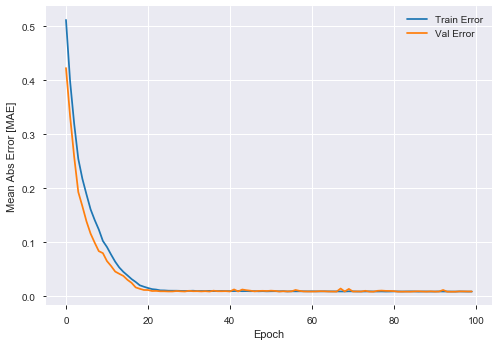

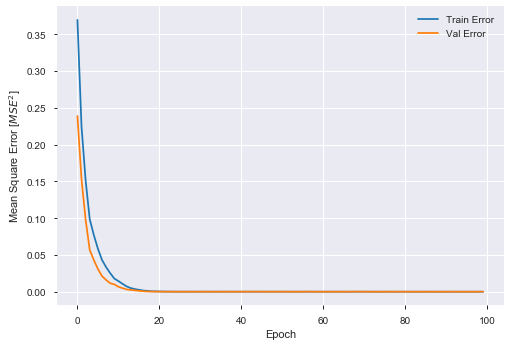

In [112]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'], # <- verificar se "mae" está na lista hist.keys() 
                                         #    (pode ser mean_absolute_error dependendo da versão do tf)
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    #plt.ylim([0,100]) isso aqui força o limite no y, se não der 
    # o plt calcula automático

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MSE^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    #plt.ylim([0,1000])

plot_history(history)

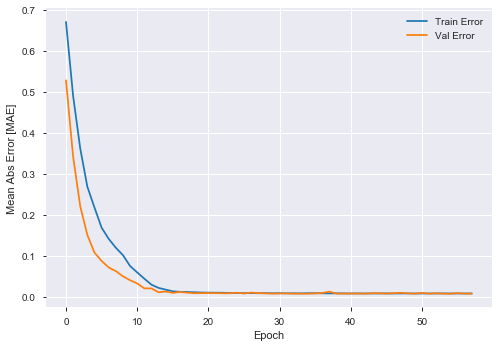

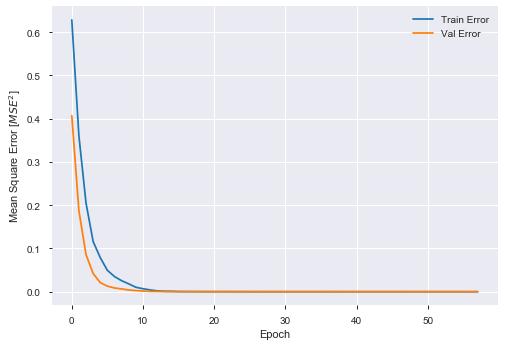

In [113]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

plot_history(history)

In [114]:
mean_absolute_percentage_error, mse, mae = model.evaluate(normed_train_data, train_labels, verbose=0)

print("MSE: {:5.5f}".format(mse))
print("MAE: {:5.5f}".format(mae))

MSE: 0.00864
MAE: 0.00012


In [115]:
mean_absolute_percentage_error, mse, mae = model.evaluate(normed_test_data, test_labels, verbose=0)

print("MSE: {:5.5f}".format(mse))
print("MAE: {:5.5f}".format(mae))

MSE: 0.00818
MAE: 0.00010


(0.770405948028674, 0.8785040519713264, 0.7693407208538828, 0.8774388247965352)

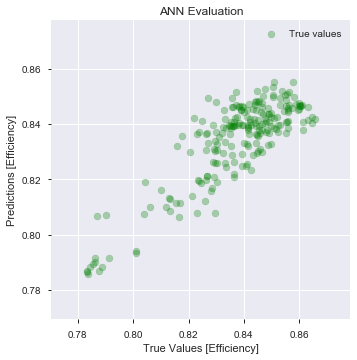

In [116]:
import matplotlib.pyplot as plt
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha = 0.3, c = 'g')
plt.title("ANN Evaluation")
plt.xlabel('True Values [Efficiency]')
plt.ylabel('Predictions [Efficiency]')
plt.legend(['True values', 'Predictions'], loc='upper right')
plt.axis('equal')
plt.axis('square')




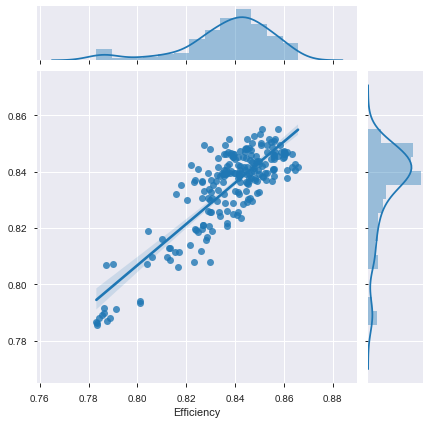

In [117]:
sns.jointplot(x=test_labels,y=test_predictions,kind='reg')

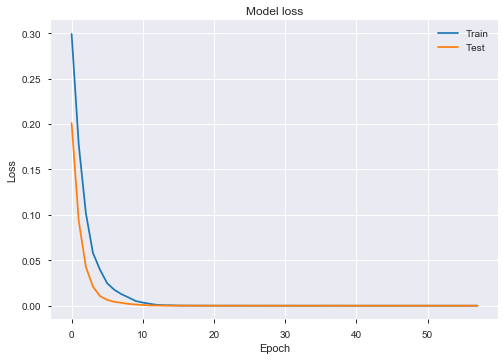

In [118]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

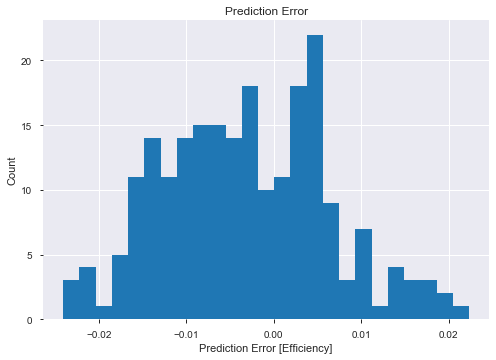

In [119]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.title("Prediction Error")
plt.xlabel("Prediction Error [Efficiency]")
_ = plt.ylabel("Count")

In [85]:
for x, y in zip(test_labels, test_predictions):
    print("%4.5f - %4.5f" % (x,y))

0.76444 - 0.81257
0.80226 - 0.80271
0.80117 - 0.80340
0.80086 - 0.80804
0.78609 - 0.80820
0.79129 - 0.80936
0.79592 - 0.80972
0.78535 - 0.80829
0.78818 - 0.80766
0.78671 - 0.80209
0.78215 - 0.80075
0.78582 - 0.79870
0.78929 - 0.79822
0.78870 - 0.79827
0.78559 - 0.79859
0.78539 - 0.79738
0.78316 - 0.79725
0.78292 - 0.79782
0.78360 - 0.79798
0.79190 - 0.79687
0.79290 - 0.80302
0.80346 - 0.80368
0.80409 - 0.80487
0.80158 - 0.80578
0.80479 - 0.80787
0.80683 - 0.80886
0.80377 - 0.80864
0.80738 - 0.80690
0.81061 - 0.80795
0.80712 - 0.81286
0.80505 - 0.81287
0.78980 - 0.81208
0.79461 - 0.81194
0.79607 - 0.81272
0.79373 - 0.81093
0.79118 - 0.81243
0.79736 - 0.81222
0.79992 - 0.80456
0.78576 - 0.80541
0.80644 - 0.80779
0.80650 - 0.81116
0.80741 - 0.81490
0.79042 - 0.81360
0.78905 - 0.81363
0.78618 - 0.81337
0.80501 - 0.81300
0.81561 - 0.81311
0.81414 - 0.81496
0.82832 - 0.81498
0.82439 - 0.81653
0.82578 - 0.81389
0.82471 - 0.81757
0.83985 - 0.82082
0.83840 - 0.82067
0.83657 - 0.81757
0.84365 - 

In [120]:
new_inputs = pd.read_excel('DS_FF_DoE_AS.xlsx')
new_inputs

,Excesso_O2,T_out_coal_mill_A,Mill_A_classifier_velocity,Secondary_air_flow_A,Pressao_do_coletor_de_Ar_Secundario,Pressao_do_coletor_de_Ar_Primario,Flow_primary_air_Mill_A,Efficiency
0,1.50,75,90,68,78,77.5,24,NaN
1,2.25,85,100,68,78,77.5,26,NaN
2,3.00,75,110,68,78,77.5,24,NaN
3,3.00,85,100,58,68,77.5,24,NaN
4,1.50,65,100,58,68,77.5,24,NaN
5,3.00,75,100,68,68,85.0,26,NaN
6,2.25,65,100,68,58,77.5,26,NaN
7,2.25,75,100,68,68,77.5,24,NaN
8,2.25,65,100,68,78,77.5,26,NaN
9,3.00,85,100,78,68,77.5,24,NaN


In [121]:
new_dataset= new_inputs.drop('Efficiency', axis = 1)

In [122]:
new_train_stats = new_inputs.describe()
new_train_stats.pop("Efficiency")
new_train_stats = new_train_stats.transpose()

In [123]:
def new_norm(y):
    return (y - new_train_stats['mean'])/new_train_stats['std']

In [124]:
new_ds_ff = new_norm(new_dataset)

In [125]:
new_y=model.predict(new_ds_ff.to_numpy()).flatten()

In [126]:
print(*new_y, sep = "\n") 

0.8305997
0.8246686
0.83094007
0.83793664
0.8262826
0.80632794
0.80985683
0.8333456
0.80626774
0.8393388
0.8255372
0.8138913
0.83924913
0.82030594
0.8119919
0.8187445
0.8190869
0.82004523
0.8521633
0.83761287
0.8279569
0.8422307
0.83160275
0.83886075
0.8381529
0.824579
0.8504282
0.8245411
0.8336862
0.82004136
0.83892477
0.8528461
0.8275695
0.8358708
0.8148266
0.8463455
0.84351176
0.8268819
0.8333456
0.839588
0.8578342
0.83238137
0.8440288
0.8260176
0.8499674
0.8346694
0.8431036
0.8384085
0.83954805
0.81937337
0.8186303
0.8403383
0.8333456
0.82412827
0.8573832
0.8445607
0.84526384
0.8254395
0.8262136


In [98]:
y_correct = df_2.filter(['Efficiency'], axis = 1) #puxar as saídas dos samples
y_correct

,Efficiency
0,0.79435
1,0.79676
2,0.79442
3,0.79635
4,0.78517
...,...
5977,0.84529
5978,0.84827
5979,0.84845
5980,0.84905


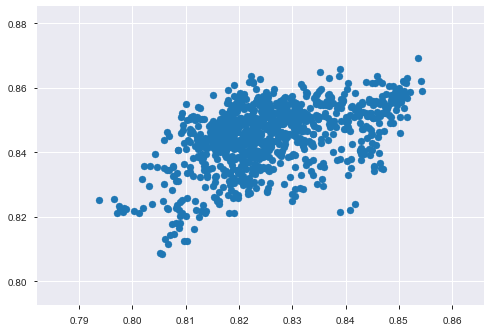

In [95]:
plt.scatter(new_y,y_correct)